In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
from IPython.display import HTML

%matplotlib inline

## Camera calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

images_with_corners = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        images_with_corners.append(
            cv2.drawChessboardCorners(img, (9,6), corners, ret))        

# Chose one of the images to get the shaoe.
img = cv2.imread("./camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)        

## Single Image

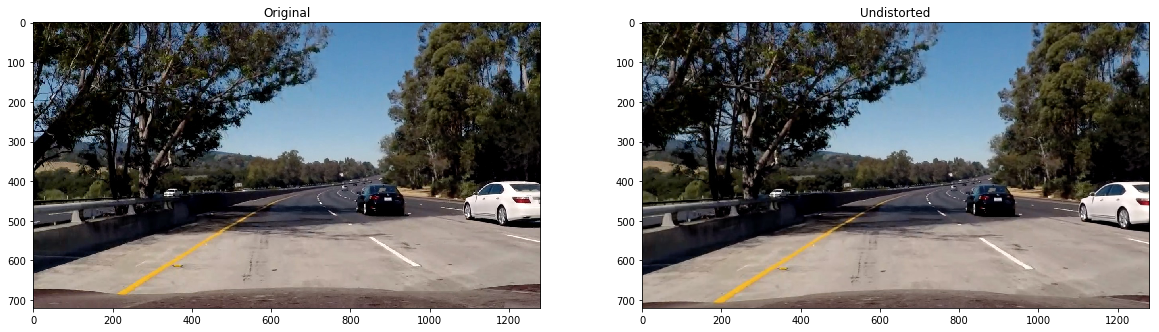

In [98]:
test_img = cv2.imread("./test_images/test5.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undistorted_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)

# Plot original and undistorted image side by side.
fig, (ax_orig, ax2_undist) = plt.subplots(1, 2, figsize=(20, 20))
ax_orig.imshow(test_img)
ax_orig.set_title('Original')
ax2_undist.imshow(undistorted_test_img)
ax2_undist.set_title('Undistorted')

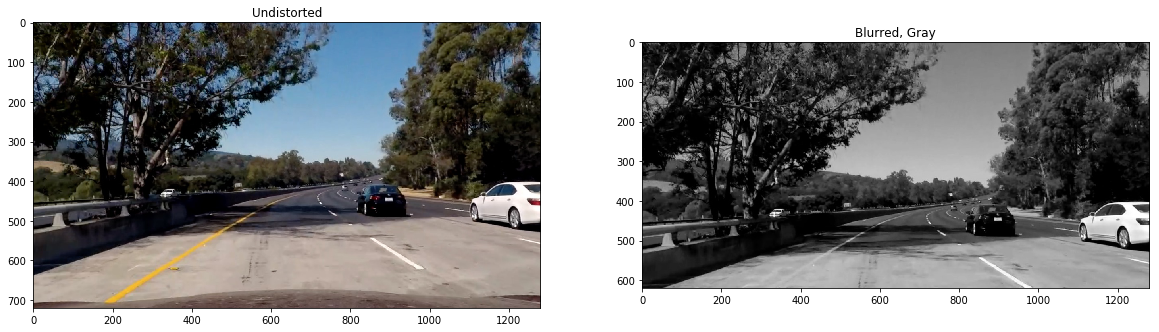

In [112]:
# Gaussian Blur
#gb_kernel_size = 5
#gb_undistorted_test_img = cv2.GaussianBlur(undistorted_test_img, (gb_kernel_size, gb_kernel_size), 0)
#gb_undistorted_test_img = undistorted_test_img
gray_undistorted_test_img = cv2.cvtColor(undistorted_test_img, cv2.COLOR_RGB2GRAY)

gray_undistorted_test_img = gray_undistorted_test_img[range(0, gray_undistorted_test_img.shape[0] - 100), :]

# Plot original and undistorted image side by side.
fig, (ax_orig, ax2_undist) = plt.subplots(1, 2, figsize=(20, 20))
ax_orig.imshow(undistorted_test_img)
ax_orig.set_title('Undistorted')
ax2_undist.imshow(gray_undistorted_test_img, cmap='gray')
ax2_undist.set_title('Blurred, Gray')

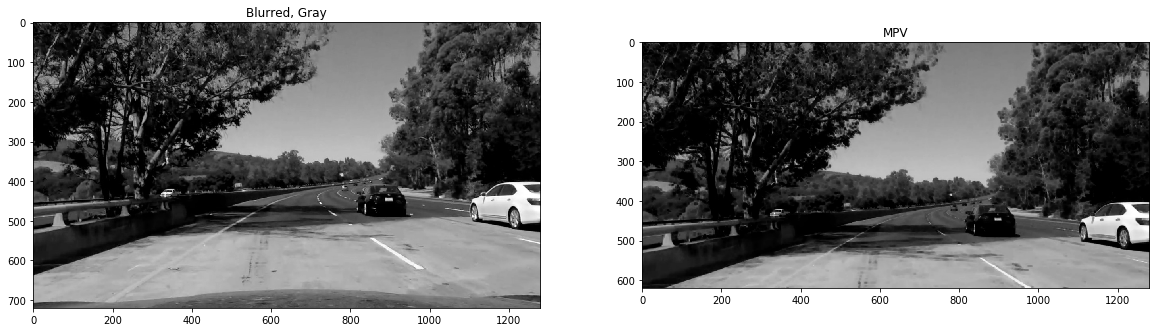

In [113]:
def minimum_pixel_value_filter(img):
    result = np.zeros_like(img)
    for y in range(0, img.shape[0]):
        for x in range(0, img.shape[1]):
            y_min = max(0, y - 1)
            y_max = min(img.shape[0] - 1, y + 1)
            x_min = max(0, x - 1)
            x_max = min(img.shape[1] - 1, x + 1)
            result[y,x] = np.min(img[range(y_min, y_max + 1), :][:, range(x_min, x_max + 1)])
    return result

mpv_filter_img = minimum_pixel_value_filter(gray_undistorted_test_img)
# Plot original and undistorted image side by side.
fig, (ax_orig, ax2_undist) = plt.subplots(1, 2, figsize=(20, 20))
ax_orig.imshow(gb_gray_test_img, cmap='gray')
ax_orig.set_title('Blurred, Gray')
ax2_undist.imshow(mpv_filter_img, cmap='gray')
ax2_undist.set_title('MPV')

In [114]:
def findRegionalMinimaAndMean(img, numRegions):
    row_average = np.mean(img, axis = 1)
    A = []
    step = (int)(img.shape[0] / numRegions)
    for i in range(0, numRegions):
        min_idx = np.argmin(row_average[range(i * step, (i + 1) * step)])
        min_value = row_average[i * step + min_idx]
        A.append((min_value, i * step + min_idx))

    return np.mean(row_average), A

mean, A = findRegionalMinimaAndMean(mpv_filter_img, 10)

print("mean: \n", mean)
print("A: \n", A)
                                

mean: 
 72.5833807964
A: 
 [(57.4375, 61), (55.891406250000003, 67), (55.13671875, 183), (56.016406250000003, 186), (64.9375, 249), (38.203125, 371), (24.010937500000001, 400), (47.064062499999999, 473), (63.155468749999997, 505), (139.09140625000001, 558)]


In [115]:
def findHorizont(img, numRegions, threshold, top_offset, default):
    mean, A = findRegionalMinimaAndMean(img, 10)
    value,raw = A[0]
    if value < A[1][0] and value < mean and raw > top_offset:
        return raw
    for i in range(1, len(A)):
        value,raw = A[i]
        if ((value < A[i-1][0] or abs(value - A[i-1][0]) <  threshold)
            and value < A[i+1][0] and value < A[0][0]
            and value < mean and (abs(A[i+1][0] - value) > threshold)):
            return raw

    return default

Hz = findHorizont(mpv_filter_img, 20, 10, 100, 300)
print ("Horizont:\n", Hz)

Horizont:
 400


In [116]:
def laneRegionAnalysis(img, hz, k):
    cut_img = img[range(Hz, img.shape[0]), :]
    
    selected_rows = range(cut_img.shape[0] - k, cut_img.shape[0])
    selected_img = cut_img[selected_rows, :]
    b_values = np.zeros((selected_img.shape[0], 256)).astype(int)
    gray_levels = np.zeros(256)
    for i in range(0, 256):
        b = np.zeros_like(selected_img)
        b[selected_img == i] = 1
        c = np.sum(b, axis=1)
        b_values[:, i] = c
        gray_levels[i] = np.sum(c)
    b_g = np.argmax(b_values, axis = 1)
    b_v = np.max(b_values, axis = 1)
    #print ("b_g.shape\n", b_g.shape)
    #print ("b_g\n", b_g)
    #print ("b_v.shape\n", b_v.shape)
    #print ("b_v\n", b_v)
    #print("Argmax_b_v:\n", np.argmax(b_v))
    #print("GrayLevels:\n", gray_levels)
    mf_gray = np.argmax(gray_levels)
    max_gray = b_g[np.argmax(b_v)]
    dev = np.std(selected_img)
    #print("MostFrequent:\n", mf_gray)
    #print("MaxGray:\n", max_gray)
    #print("Dev:\n", dev)
    
    
    rplm_img = np.zeros_like(cut_img)
    rplm_img[cut_img  > max_gray + dev] = 1
    
    T_1 = np.sum(rplm_img, axis=1)
    T_1_nonzero = np.where(T_1 != 0)[0]
    T_1_avg = np.average(T_1[T_1_nonzero])
    T_1_selected = np.where(T_1 > T_1_avg)[0]
    rplm_img[T_1_selected, :] = np.zeros(rplm_img.shape[1])
    
    binary_image = np.zeros_like(img)
    binary_image[range(Hz, img.shape[0]), :] = rplm_img
    return binary_image

In [117]:
# Cut image from the bottom

Hz = findHorizont(mpv_filter_img, 20, 5, 100, 300)
binary_img = laneRegionAnalysis(img, Hz, 30)


ValueError: could not broadcast input array from shape (30,3) into shape (30)

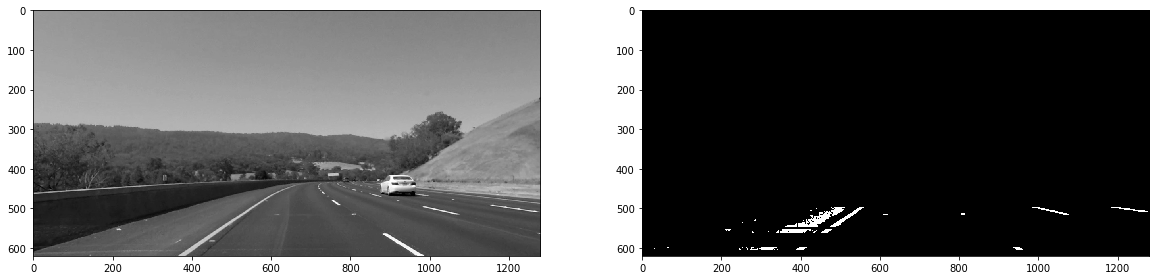

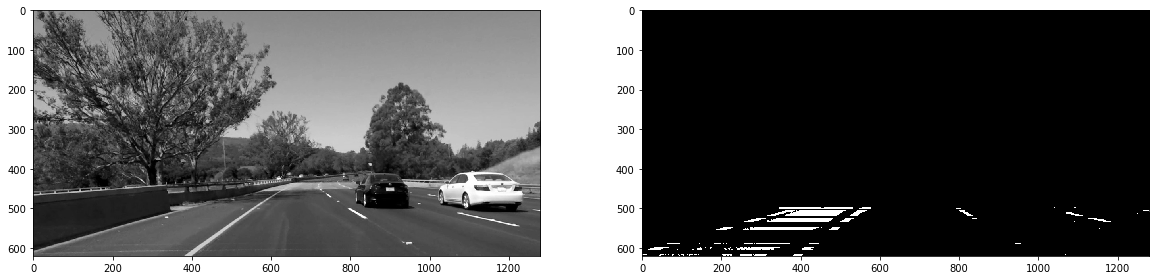

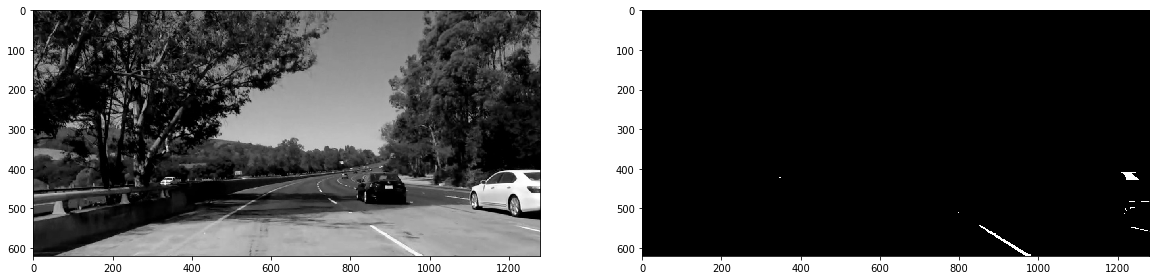

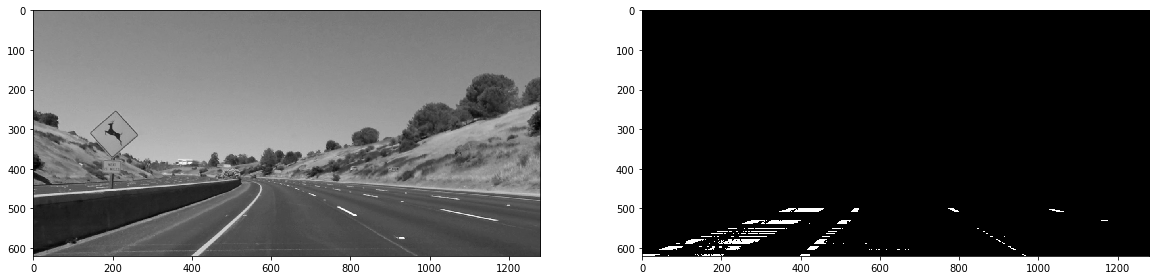

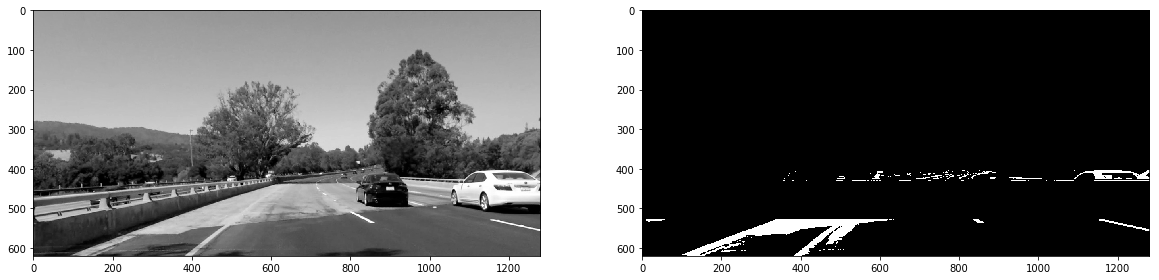

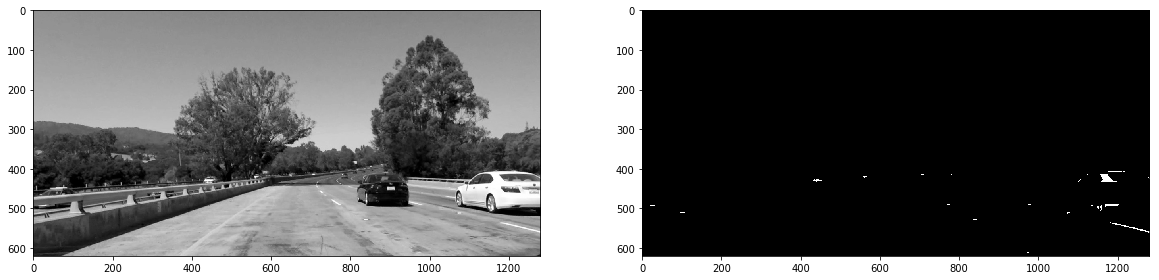

In [123]:
test_images = glob.glob('./test_images/test*.jpg')
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img = img[range(0, img.shape[0] - 100), :]
    mpv_filter_img = minimum_pixel_value_filter(img)
    Hz = findHorizont(mpv_filter_img, 20, 5, 100, 300)
    binary_img = laneRegionAnalysis(img, Hz, 30)
    
    # Plot original and undistorted image side by side.
    fig, (ax_orig, ax2_bin) = plt.subplots(1, 2, figsize=(20, 20))
    ax_orig.imshow(img, cmap='gray')
    #ax_orig.set_title('orig')
    ax2_bin.imshow(binary_img, cmap='gray')
    #ax2_bin.set_title('bin')
    

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


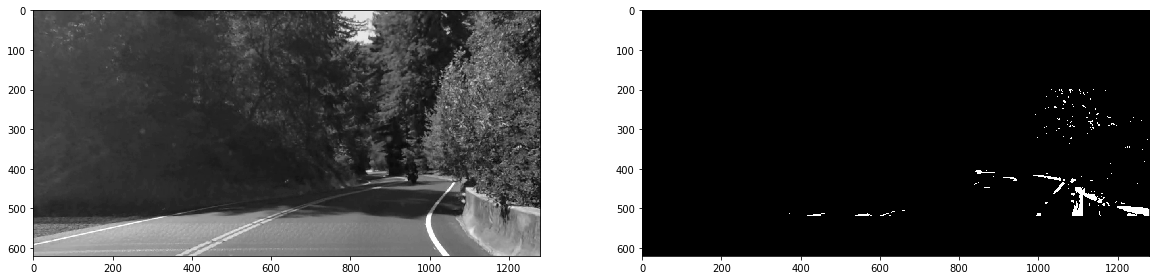

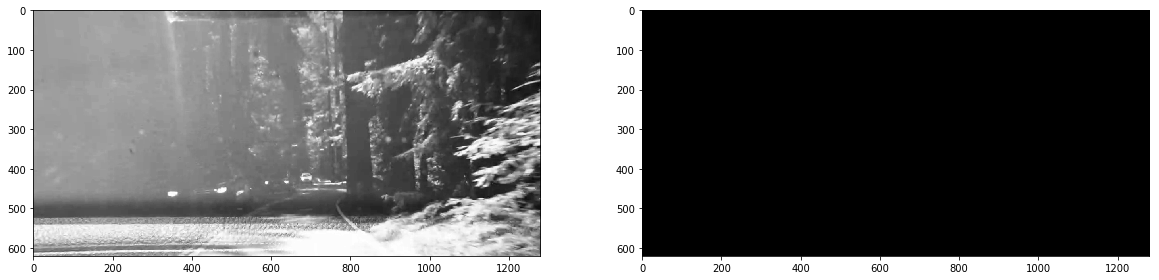

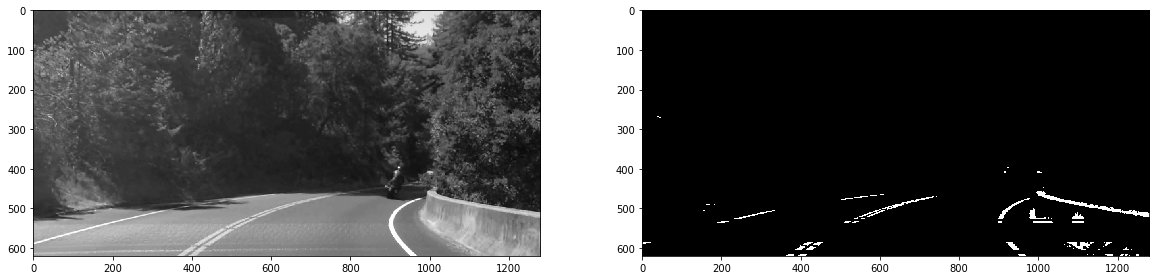

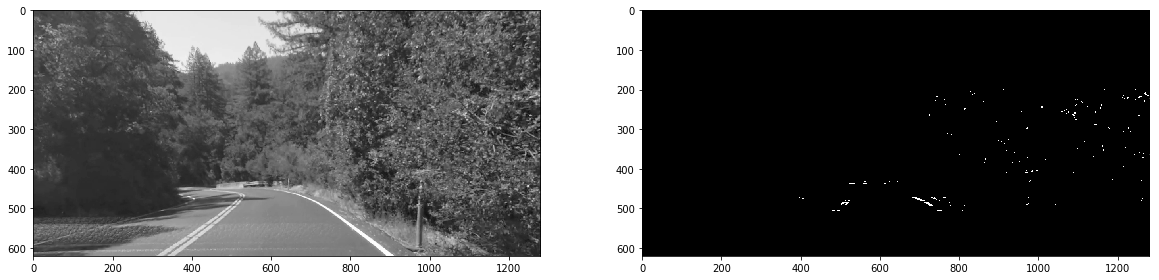

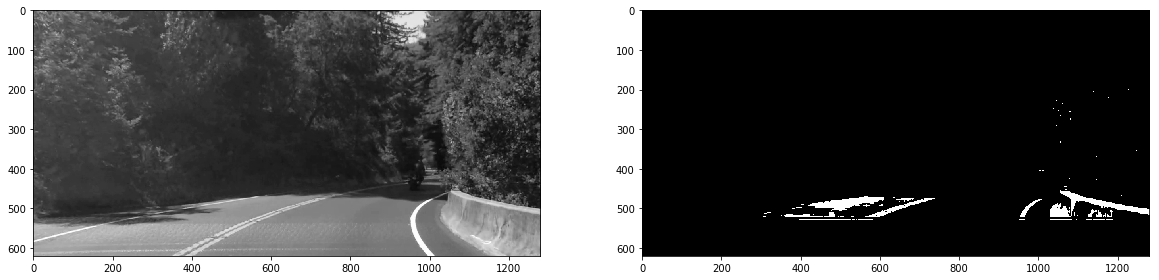

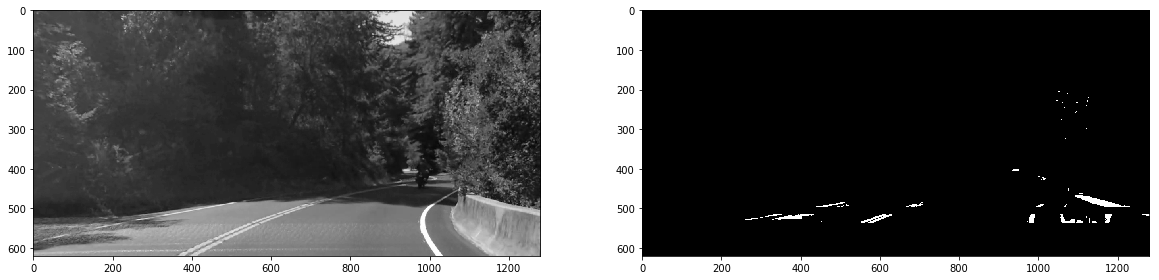

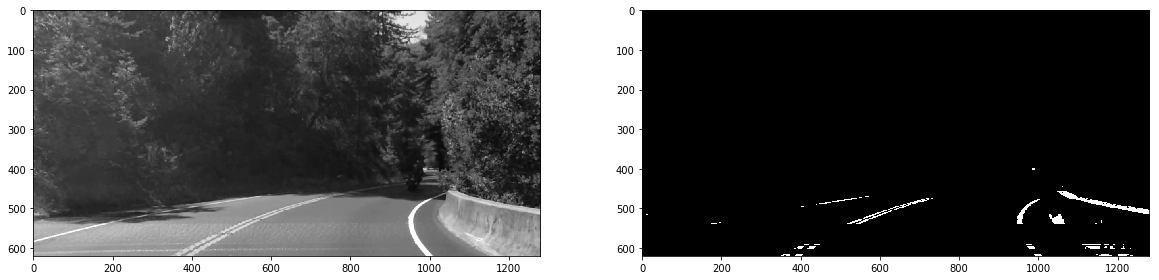

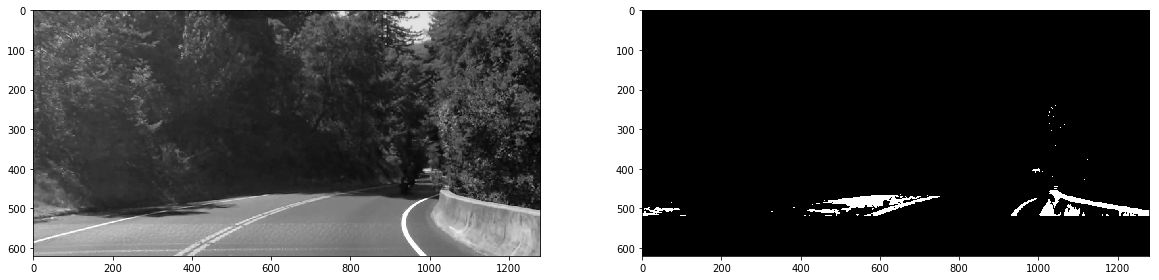

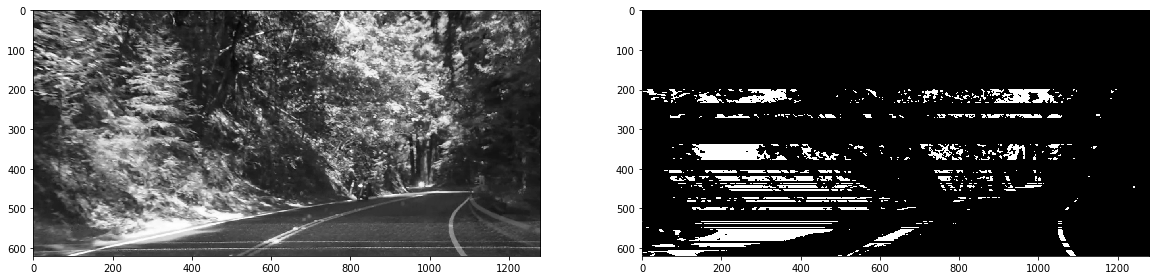

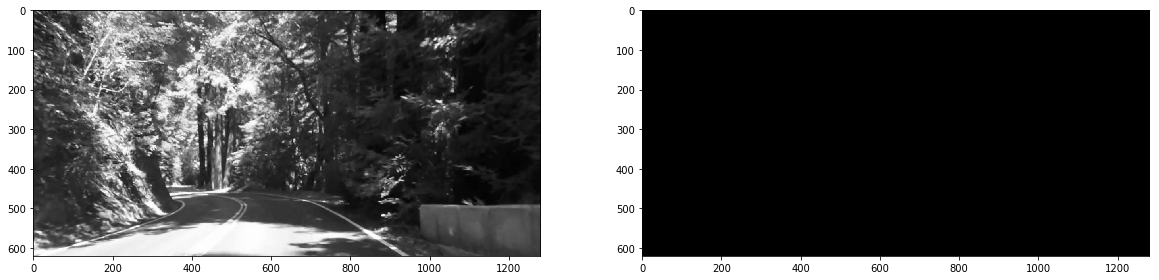

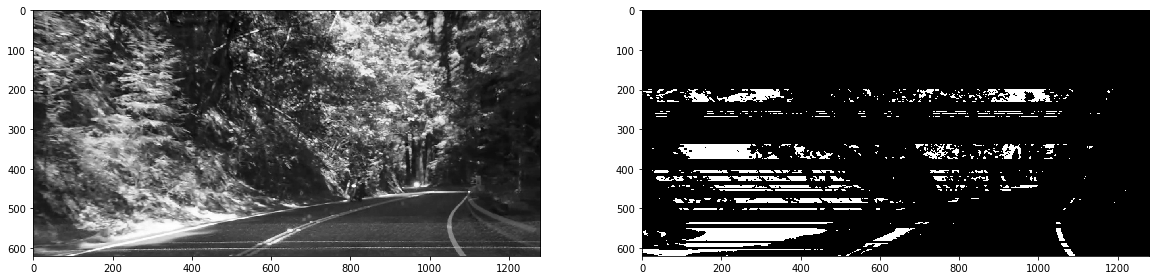

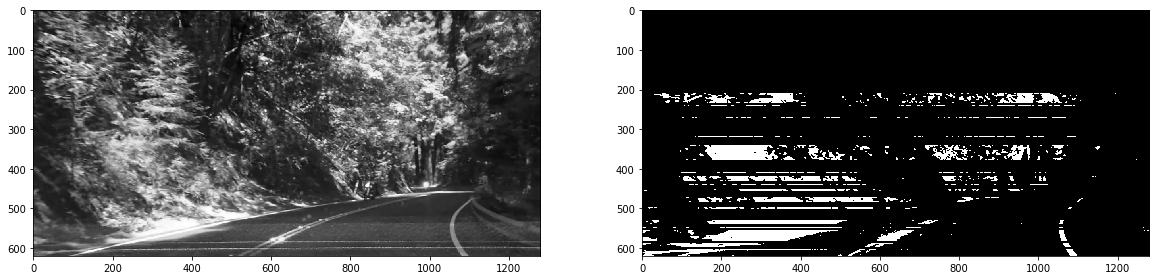

In [124]:
test_images = glob.glob('./of_interest/*.png')
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img = img[range(0, img.shape[0] - 100), :]
    #mpv_filter_img = minimum_pixel_value_filter(img)
    #Hz = findHorizont(mpv_filter_img, 20, 5, 100, 300)
    Hz = 200
    binary_img = laneRegionAnalysis(img, Hz, 30)
    
    # Plot original and undistorted image side by side.
    fig, (ax_orig, ax2_bin) = plt.subplots(1, 2, figsize=(20, 20))
    ax_orig.imshow(img, cmap='gray')
    #ax_orig.set_title('orig')
    ax2_bin.imshow(binary_img, cmap='gray')
    #ax2_bin.set_title('bin')